# Gesture based control for consumer electronics

Importing required libraries

In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy
a = [[1,2,5],[3,4,6]]
b = numpy.array(a)
print(b[(0),:])

[1 2 5]


In [57]:
a = cv2.imread("DataSet/C/1.png")
img1 = a.copy()
img1[:,:,0] = cv2.normalize(a[:,:,0], dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img1[:,:,1] = cv2.normalize(a[:,:,1], dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img1[:,:,2] = cv2.normalize(a[:,:,2], dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

Conversion of RGB image into grayscale and normalization

In [58]:
img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
k = cv2.normalize(img, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

GussianBlur and OTSU's thresholding

255
273


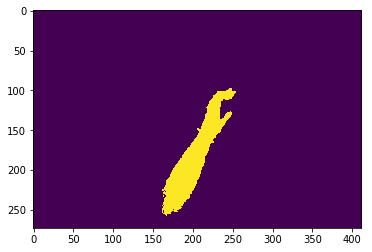

In [66]:
blur = cv2.GaussianBlur(img,(5,5),0)
ret, thresh1 = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU)
stretch_near = cv2.resize(thresh1, (255, 255),  
               interpolation = cv2.INTER_NEAREST)
print(len(stretch_near))
print(len(thresh1))
plt.imshow(thresh1)

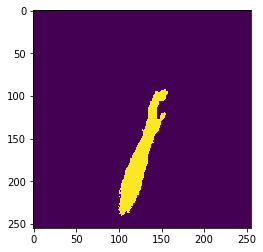

In [67]:
plt.imshow(stretch_near)

Showing image

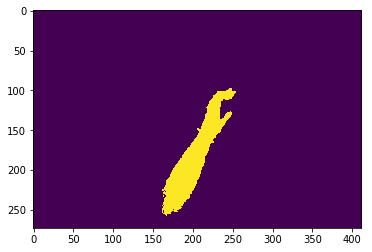

In [51]:
plt.imshow(thresh1)

[ 161   98   93  160 4358]


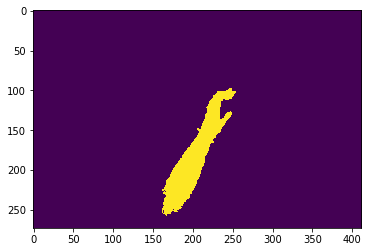

In [124]:
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh1, connectivity=4)
sizes = stats[:, -1]

max_label = 1
max_size = sizes[1]
for i in range(2, nb_components):
    if sizes[i] > max_size:
        max_label = i
        max_size = sizes[i]

img2 = np.zeros(output.shape)
img2[output == max_label] = 255
plt.imshow(img2)
print(stats[max_label])

Rescaling of image

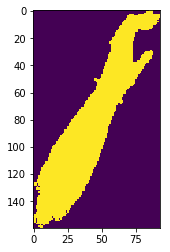

In [134]:
img2 = numpy.array(img2)
new_image = img2[stats[max_label][1]:stats[max_label][1]+stats[max_label][3],stats[max_label][0]:stats[max_label][0]+stats[max_label][2]]
image_for_input = cv2.resize(img2, (100, 100),  
               interpolation = cv2.INTER_NEAREST)
plt.imshow(new_image) 

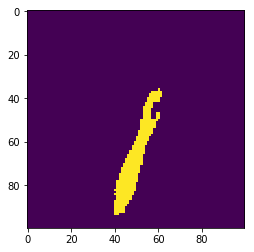

In [135]:
plt.imshow(image_for_input)

In [84]:
from sklearn.neural_network import MLPClassifier

start_time = time.time()
clf = MLPClassifier(hidden_layer_sizes = (100,100), activation = 'relu', solver = 'sgd', max_iter=100, batch_size=100, verbose = 'true', tol=10**-6, learning_rate = 'invscaling', learning_rate_init = 0.2, power_t = 0.5)
clf.fit(input_data_train,output_data_train)
end_time = time.time()
print("Train", clf.score(input_data_train,output_data_train))
print("Test", clf.score(input_data_test,output_data_test))
print("Time", end_time - start_time)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

# load pima indians dataset
dataset = numpy.loadtxt("Alphabets/train.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:784]
Y = dataset[:,784]

# create model
model = Sequential()
model.add(Dense(3, input_dim=4, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])


# Fit the model
model.fit(X, Y, epochs=100, batch_size=400)

# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))